In [31]:
from statsmodels.tsa.arima_model import ARIMA
from Authenticator import read_auth
import matplotlib.pyplot as plt
from datetime import datetime
import ReadFromDB as RDB
import sklearn as sk
import pandas as pd
import numpy as np
import scipy as sc
import time


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.rcParams['figure.figsize'] = (20,4)

In [32]:
# reload after changes have been made
from importlib import reload
reload(RDB)
for i in dir(RDB)[8:]:
    print(i,end=', ')

create_station_dictionary, get_static_data, pd, read_auth, read_weather, station, station_dict_row, 

**An Arima time series will be used to generate a plot for each station**

In [33]:
static_data = RDB.get_static_data()
station_numbers = list(static_data['number'].astype(int))

In [34]:
weather = RDB.read_weather(5)
# weather.head(1)

In [70]:
# read data from database
station_data = RDB.station(5)

# remove any data where the station is closed
station_data = station_data[station_data.status=='OPEN']

# convert timestamps from milliseconds to seconds and change type to int
station_data.last_updated = station_data.last_updated.apply(lambda x: int(x)/1000)

#convert the timestamps to date_times
convert = (lambda x : datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
station_data.last_updated = station_data.last_updated.apply(convert)
station_data.last_updated = pd.to_datetime(station_data.last_updated)

# set timestamp as index
data = station_data.set_index('last_updated')

# sorting indices (should be redundant)
data.sort_index(inplace=True)
data.index.name='time'

# resampling data to every half hour
timestep = 60
data = data.resample(f'{timestep}T').mean()

# drop NaN, round float to int. 
data = data.dropna()
data = data.round(0).astype(int)

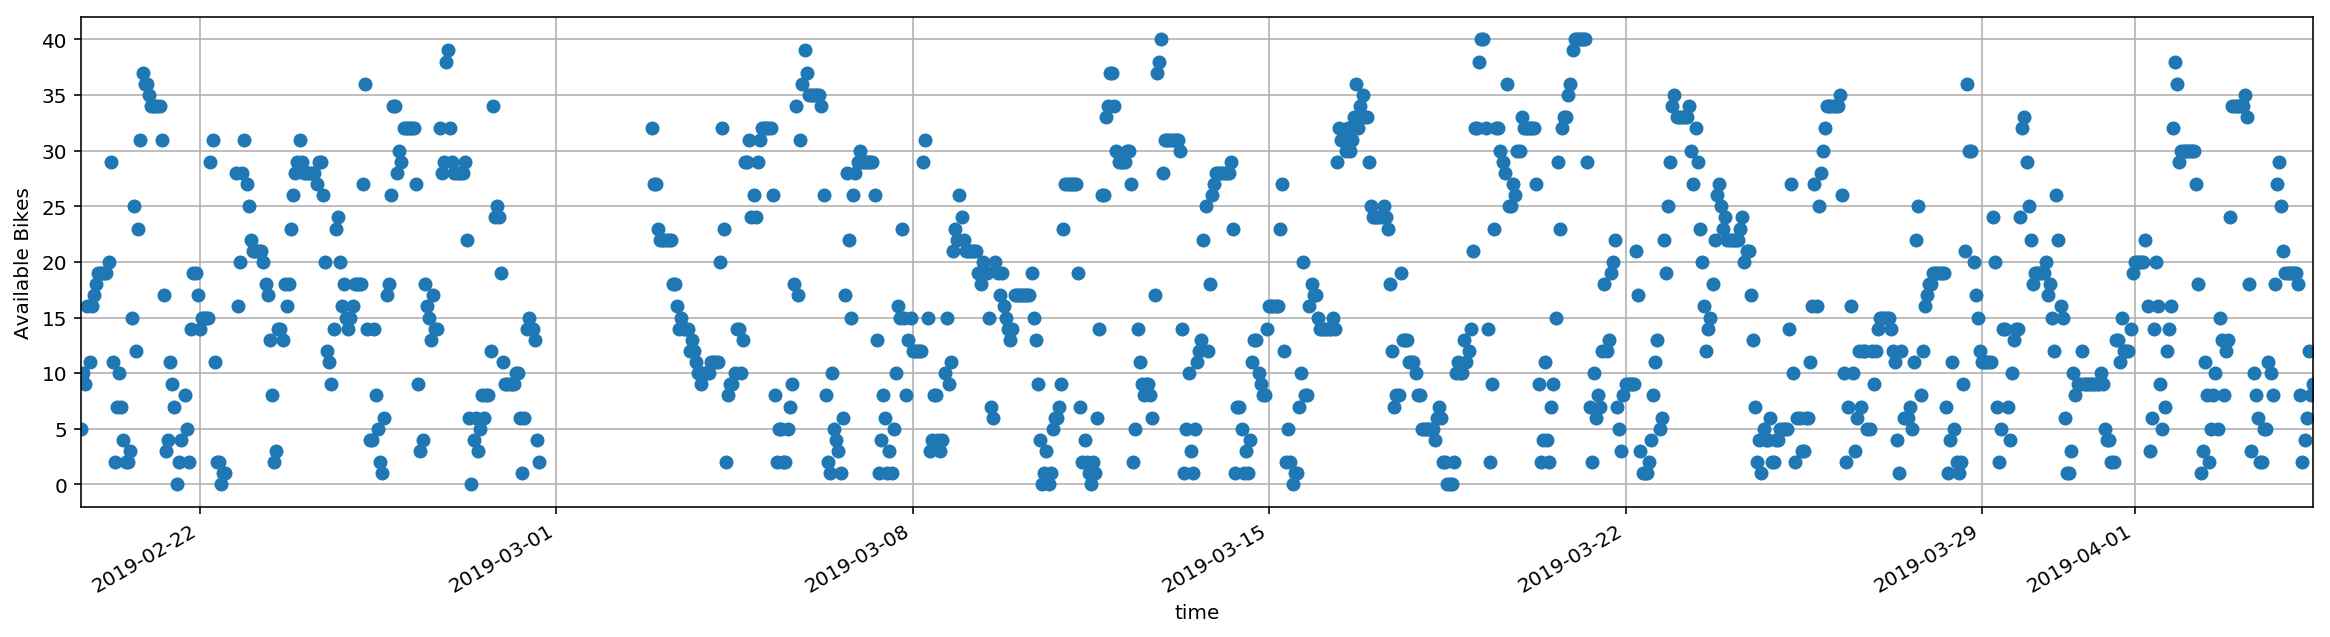

In [77]:
plt.figure(figsize=(20,5))
plot = data['available_bikes'].plot(style='o')
plot.set_ylabel('Available Bikes')
plt.grid(True, which='both')

**Splitting Data into train and test sets**

In [114]:
# split data into train and test sets. (there is a pause in data between the two)
testbikes = data['available_bikes'].loc[:'2019-02-28 00:15:00']
bikes = data['available_bikes'].loc['2019-03-01 00:15:00':]

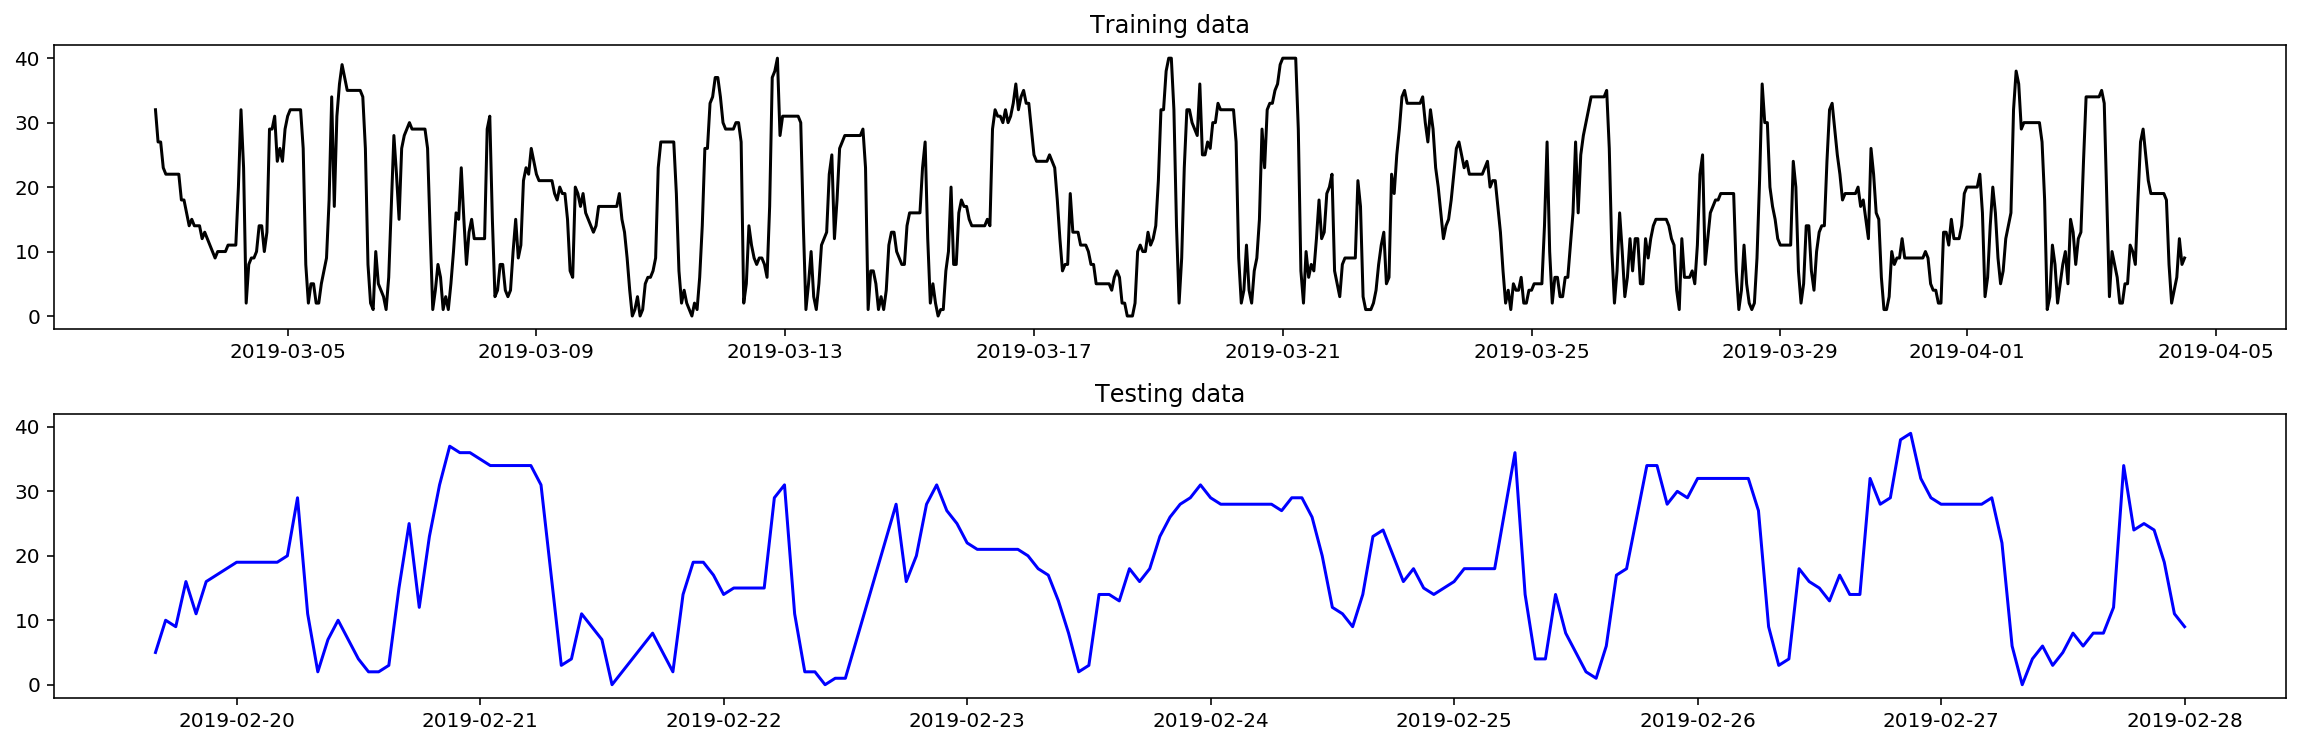

In [113]:
f, axes = plt.subplots(2, 1, sharey=True, figsize=(20,6))
plt.subplots_adjust(hspace=0.3)

axes[0].set_title('Training data')
axes[0].plot(bikes,'k-')

axes[1].set_title('Testing data')
axes[1].plot(testbikes,'b-')

Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band. See the Wikipedia entry for more about autocorrelation plots.

**Model Application**

In [ ]:
# splitting Model data at skip point.

model = ARIMA(data.available_bikes, order=(5,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.xticks(rotation = 25)

In [ ]:
residuals.plot(kind='kde')
print(residuals.describe())

ValueError: operands could not be broadcast together with shapes (2015,) (782,) (2015,) 

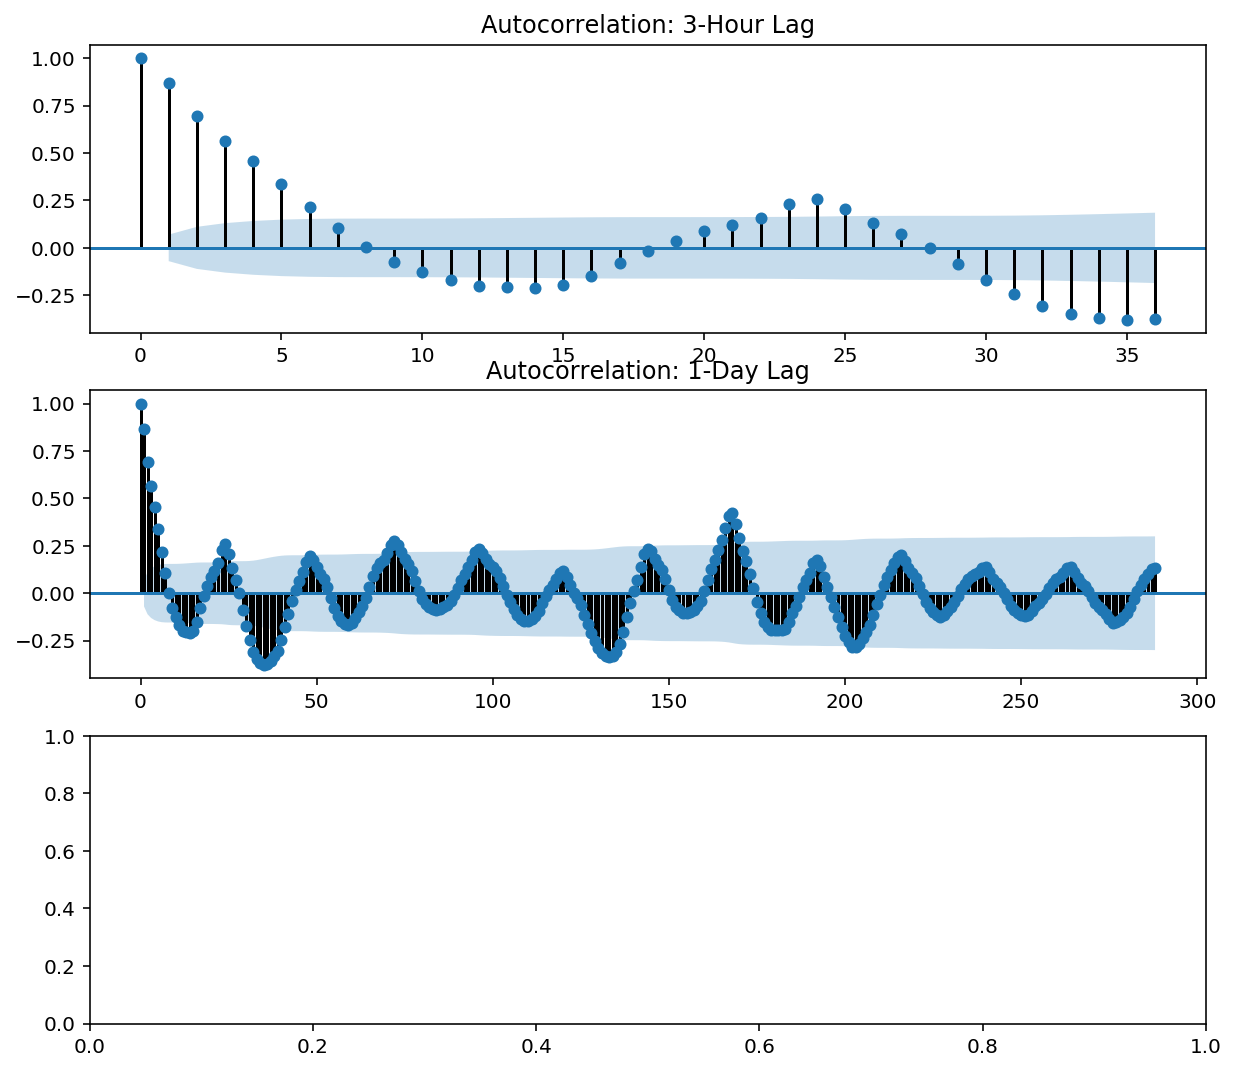

In [116]:
import statsmodels.tsa.api as smt


def plot_multi_acf(data, lags, titles, ylim=None, partial=False):
    num_plots = len(lags)
    fig, ax = plt.subplots(len(lags), 1, figsize=(10, 3 * num_plots));
    if num_plots == 1:
        ax = [ax]
    acf_func = smt.graphics.plot_pacf if partial else smt.graphics.plot_acf
    for idx, (lag, title) in enumerate(zip(lags, titles)):
        fig = acf_func(data, lags=lag, ax=ax[idx], title=title);
        if ylim is not None:
            ax[idx].set_ylim(ylim);
    
    fig.tight_layout();

period_minutes = 5
samples_per_hour = int(60 / period_minutes)
samples_per_day = int(24 * samples_per_hour)
samples_per_week = int(7 * samples_per_day)
    
lags = [3 * samples_per_hour, samples_per_day, samples_per_week]
titles= ['Autocorrelation: 3-Hour Lag',
         'Autocorrelation: 1-Day Lag',
         'Autocorrelation: 1-Week Lag']

plot_multi_acf(bikes, lags, titles)
